In [1]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
%matplotlib inline
%load_ext autoreload
%autoreload 2
import random
import pdb
# from multiprocessing import Process, Manager
# from multiprocessing import set_start_method

In [2]:
import sys
sys.path.insert(0, '/home/nkotelevskii/github/corrected_l2hmc/l2hmc_pytorch/l2hmc/utils/')

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = "cpu"
device

'cuda:0'

In [4]:
from func_utils_pt import acl_spectrum, ESS

In [5]:
from distributions_pt import Gaussian
from layers_pt import Net
from dynamics_pt import Dynamics
from sampler_pt import propose
from notebook_utils_pt import get_hmc_samples

In [6]:
network = Net

In [7]:
x_dim = 2
mu = np.zeros(2,)
mu = torch.tensor(mu).to(device)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]])
cov = torch.tensor(cov).to(device)

distribution = Gaussian(mu, cov, device=device)
dynamics = Dynamics(x_dim, distribution.get_energy_function(), T=10, eps=0.1, net_factory=network, device=device)

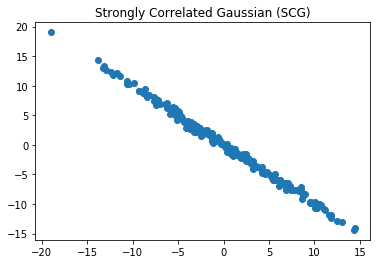

In [8]:
S = distribution.get_samples(200)
plt.title('Strongly Correlated Gaussian (SCG)')
plt.scatter(S[:, 0], S[:, 1])
plt.show()

In [9]:
n_steps = 5000
n_samples = 200
scale = torch.tensor(0.1, device=device)

In [10]:
optim = Adam(dynamics.parameters())

In [11]:
# [p for p in dynamics.parameters()] 

In [12]:
dynamics.alpha

Parameter containing:
tensor(0.1000, device='cuda:0', requires_grad=True)

In [13]:
scheduler = StepLR(optim, step_size=1000, gamma=0.96)

def criterion(v1, v2):
    return scale * (torch.mean(1.0 / v1) + torch.mean(1.0 / v2)) + (-torch.mean(v1) - torch.mean(v2)) / scale

for t in tqdm(range(n_steps)):    
    if(t==0):
        x = torch.randn(n_samples, x_dim, dtype=torch.float32, device=device)
    else:
        x = output[0]

    z = torch.randn_like(x, dtype=torch.float32, device=device)

    optim.zero_grad()
    Lx, _, log_px, output, _ = propose(x, dynamics, do_mh_step=True, device=device)
    Lz, _, log_pz, _, _ = propose(z, dynamics, do_mh_step=False, device=device)
    
    px = log_px.exp()
    pz = log_pz.exp()
    

    v1 = (torch.sum((x - Lx)**2, dim=1) * px) + torch.tensor(1e-4, dtype=torch.float32, device=device)
    v2 = (torch.sum((z - Lz)**2, dim=1) * pz) + torch.tensor(1e-4, dtype=torch.float32, device=device)
    scale = torch.tensor(0.1, dtype=torch.float32, device=device)

    loss = criterion(v1, v2)
    loss.backward()

    optim.step()
#     pdb.set_trace()

    if t % 100 == 0:
        current_lr = None
        for param_group in optim.param_groups:
            current_lr = param_group['lr']
        print ('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss.item(), np.mean(px.cpu().detach().numpy()), current_lr))
    scheduler.step()
    optim.zero_grad()

  0%|          | 1/5000 [00:00<37:08,  2.24it/s]

Step: 0 / 5000, Loss: 1.88e+03, Acceptance sample: 0.00, LR: 0.00100


  2%|▏         | 101/5000 [00:30<24:29,  3.33it/s]

Step: 100 / 5000, Loss: 2.01e+01, Acceptance sample: 0.78, LR: 0.00100


  4%|▍         | 201/5000 [01:00<24:09,  3.31it/s]

Step: 200 / 5000, Loss: -6.22e+01, Acceptance sample: 0.63, LR: 0.00100


  6%|▌         | 301/5000 [01:30<23:27,  3.34it/s]

Step: 300 / 5000, Loss: -4.51e+02, Acceptance sample: 0.46, LR: 0.00100


  8%|▊         | 401/5000 [02:01<23:16,  3.29it/s]

Step: 400 / 5000, Loss: -2.23e+03, Acceptance sample: 0.28, LR: 0.00100


 10%|█         | 501/5000 [02:31<22:47,  3.29it/s]

Step: 500 / 5000, Loss: -5.19e+03, Acceptance sample: 0.27, LR: 0.00100


 12%|█▏        | 601/5000 [03:01<22:03,  3.32it/s]

Step: 600 / 5000, Loss: -4.26e+03, Acceptance sample: 0.30, LR: 0.00100


 14%|█▍        | 701/5000 [03:31<21:50,  3.28it/s]

Step: 700 / 5000, Loss: -4.67e+03, Acceptance sample: 0.31, LR: 0.00100


 16%|█▌        | 801/5000 [04:01<20:56,  3.34it/s]

Step: 800 / 5000, Loss: -4.98e+03, Acceptance sample: 0.34, LR: 0.00100


 18%|█▊        | 901/5000 [04:31<20:15,  3.37it/s]

Step: 900 / 5000, Loss: -5.43e+03, Acceptance sample: 0.36, LR: 0.00100


 20%|██        | 1001/5000 [05:02<20:14,  3.29it/s]

Step: 1000 / 5000, Loss: -4.90e+03, Acceptance sample: 0.33, LR: 0.00096


 22%|██▏       | 1101/5000 [05:32<19:33,  3.32it/s]

Step: 1100 / 5000, Loss: -5.50e+03, Acceptance sample: 0.29, LR: 0.00096


 24%|██▍       | 1201/5000 [06:02<19:21,  3.27it/s]

Step: 1200 / 5000, Loss: -6.38e+03, Acceptance sample: 0.35, LR: 0.00096


 26%|██▌       | 1301/5000 [06:32<18:23,  3.35it/s]

Step: 1300 / 5000, Loss: -5.07e+03, Acceptance sample: 0.37, LR: 0.00096


 28%|██▊       | 1401/5000 [07:02<17:30,  3.43it/s]

Step: 1400 / 5000, Loss: -5.72e+03, Acceptance sample: 0.32, LR: 0.00096


 30%|███       | 1501/5000 [07:32<17:25,  3.35it/s]

Step: 1500 / 5000, Loss: -4.96e+03, Acceptance sample: 0.31, LR: 0.00096


 32%|███▏      | 1601/5000 [08:01<16:53,  3.35it/s]

Step: 1600 / 5000, Loss: -5.94e+03, Acceptance sample: 0.34, LR: 0.00096


 34%|███▍      | 1701/5000 [08:31<16:29,  3.33it/s]

Step: 1700 / 5000, Loss: -7.88e+03, Acceptance sample: 0.37, LR: 0.00096


 36%|███▌      | 1801/5000 [09:01<15:25,  3.46it/s]

Step: 1800 / 5000, Loss: -6.08e+03, Acceptance sample: 0.30, LR: 0.00096


 38%|███▊      | 1901/5000 [09:30<15:20,  3.37it/s]

Step: 1900 / 5000, Loss: -5.82e+03, Acceptance sample: 0.33, LR: 0.00096


 40%|████      | 2001/5000 [10:00<15:10,  3.29it/s]

Step: 2000 / 5000, Loss: -6.11e+03, Acceptance sample: 0.30, LR: 0.00092


 42%|████▏     | 2101/5000 [10:30<14:24,  3.35it/s]

Step: 2100 / 5000, Loss: -6.62e+03, Acceptance sample: 0.35, LR: 0.00092


 44%|████▍     | 2201/5000 [11:00<13:48,  3.38it/s]

Step: 2200 / 5000, Loss: -6.88e+03, Acceptance sample: 0.31, LR: 0.00092


 46%|████▌     | 2301/5000 [11:30<13:49,  3.25it/s]

Step: 2300 / 5000, Loss: -7.27e+03, Acceptance sample: 0.35, LR: 0.00092


 48%|████▊     | 2401/5000 [12:01<13:16,  3.26it/s]

Step: 2400 / 5000, Loss: -6.55e+03, Acceptance sample: 0.36, LR: 0.00092


 50%|█████     | 2501/5000 [12:31<12:17,  3.39it/s]

Step: 2500 / 5000, Loss: -7.82e+03, Acceptance sample: 0.35, LR: 0.00092


 52%|█████▏    | 2601/5000 [13:01<12:09,  3.29it/s]

Step: 2600 / 5000, Loss: -7.62e+03, Acceptance sample: 0.34, LR: 0.00092


 54%|█████▍    | 2701/5000 [13:31<11:31,  3.33it/s]

Step: 2700 / 5000, Loss: -7.68e+03, Acceptance sample: 0.31, LR: 0.00092


 56%|█████▌    | 2801/5000 [14:01<11:07,  3.30it/s]

Step: 2800 / 5000, Loss: -7.28e+03, Acceptance sample: 0.32, LR: 0.00092


 58%|█████▊    | 2901/5000 [14:31<10:33,  3.31it/s]

Step: 2900 / 5000, Loss: -7.40e+03, Acceptance sample: 0.34, LR: 0.00092


 60%|██████    | 3001/5000 [15:02<10:06,  3.30it/s]

Step: 3000 / 5000, Loss: -7.39e+03, Acceptance sample: 0.33, LR: 0.00088


 62%|██████▏   | 3101/5000 [15:32<09:29,  3.33it/s]

Step: 3100 / 5000, Loss: -6.79e+03, Acceptance sample: 0.33, LR: 0.00088


 64%|██████▍   | 3201/5000 [16:02<08:53,  3.37it/s]

Step: 3200 / 5000, Loss: -6.68e+03, Acceptance sample: 0.32, LR: 0.00088


 66%|██████▌   | 3301/5000 [16:31<08:35,  3.30it/s]

Step: 3300 / 5000, Loss: -6.97e+03, Acceptance sample: 0.30, LR: 0.00088


 68%|██████▊   | 3401/5000 [17:02<08:01,  3.32it/s]

Step: 3400 / 5000, Loss: -7.03e+03, Acceptance sample: 0.31, LR: 0.00088


 70%|███████   | 3501/5000 [17:32<07:33,  3.31it/s]

Step: 3500 / 5000, Loss: -8.15e+03, Acceptance sample: 0.32, LR: 0.00088


 72%|███████▏  | 3601/5000 [18:02<07:04,  3.29it/s]

Step: 3600 / 5000, Loss: -8.16e+03, Acceptance sample: 0.33, LR: 0.00088


 74%|███████▍  | 3701/5000 [18:33<06:35,  3.28it/s]

Step: 3700 / 5000, Loss: -7.05e+03, Acceptance sample: 0.29, LR: 0.00088


 76%|███████▌  | 3801/5000 [19:03<06:08,  3.26it/s]

Step: 3800 / 5000, Loss: -5.72e+03, Acceptance sample: 0.33, LR: 0.00088


 78%|███████▊  | 3901/5000 [19:33<05:30,  3.32it/s]

Step: 3900 / 5000, Loss: -7.80e+03, Acceptance sample: 0.30, LR: 0.00088


 80%|████████  | 4001/5000 [20:04<05:03,  3.30it/s]

Step: 4000 / 5000, Loss: -8.29e+03, Acceptance sample: 0.34, LR: 0.00085


 82%|████████▏ | 4101/5000 [20:34<04:33,  3.28it/s]

Step: 4100 / 5000, Loss: -8.40e+03, Acceptance sample: 0.36, LR: 0.00085


 84%|████████▍ | 4201/5000 [21:05<04:02,  3.29it/s]

Step: 4200 / 5000, Loss: -7.33e+03, Acceptance sample: 0.35, LR: 0.00085


 86%|████████▌ | 4301/5000 [21:35<03:31,  3.31it/s]

Step: 4300 / 5000, Loss: -7.95e+03, Acceptance sample: 0.38, LR: 0.00085


 88%|████████▊ | 4401/5000 [22:05<03:01,  3.30it/s]

Step: 4400 / 5000, Loss: -6.62e+03, Acceptance sample: 0.36, LR: 0.00085


 90%|█████████ | 4501/5000 [22:35<02:31,  3.29it/s]

Step: 4500 / 5000, Loss: -9.31e+03, Acceptance sample: 0.34, LR: 0.00085


 92%|█████████▏| 4601/5000 [23:05<02:02,  3.25it/s]

Step: 4600 / 5000, Loss: -6.84e+03, Acceptance sample: 0.35, LR: 0.00085


 94%|█████████▍| 4701/5000 [23:36<01:29,  3.35it/s]

Step: 4700 / 5000, Loss: -7.66e+03, Acceptance sample: 0.36, LR: 0.00085


 96%|█████████▌| 4801/5000 [24:06<00:59,  3.37it/s]

Step: 4800 / 5000, Loss: -7.72e+03, Acceptance sample: 0.31, LR: 0.00085


 98%|█████████▊| 4901/5000 [24:36<00:30,  3.28it/s]

Step: 4900 / 5000, Loss: -7.35e+03, Acceptance sample: 0.29, LR: 0.00085


100%|██████████| 5000/5000 [25:06<00:00,  3.32it/s]


In [14]:
dynamics.alpha

Parameter containing:
tensor(0.1281, device='cuda:0', requires_grad=True)

In [15]:
length_of_chains = 400 #2000

In [16]:
samples = torch.tensor(distribution.get_samples(n=n_samples), dtype=torch.float32, device=device)
final_samples = []

samples_ = samples
with torch.no_grad():
#     pdb.set_trace()
    for t in tqdm(range(length_of_chains)):
        final_samples.append(samples_.cpu().numpy())
        _, _, _, samples_, _ = propose(samples_, dynamics, do_mh_step=True, device=device)
        samples_ = samples_[0].detach()

100%|██████████| 400/400 [00:24<00:00, 16.41it/s]


In [ ]:
L2HMC_samples = np.array(final_samples)
with torch.no_grad():
    HMC_samples_1 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), steps=length_of_chains, samples=samples, device=device)
    HMC_samples_2 = get_hmc_samples(2, 0.15, distribution.get_energy_function(), steps=length_of_chains, samples=samples, device=device)
    HMC_samples_3 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), steps=length_of_chains, samples=samples, device=device)

 60%|██████    | 240/400 [00:04<00:02, 54.80it/s]

In [ ]:
L2HMC_samples.shape

In [ ]:
HMC_samples_1.shape

In [ ]:
# from func_utils_pt import acl_spectrum, ESS

In [ ]:
scale = np.sqrt(np.trace(cov.cpu().detach().numpy()))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

In [ ]:
points_to_plot = np.min([300, length_of_chains - 1])
xaxis = 10 * np.arange(points_to_plot)
plt.plot(xaxis, L2HMC[:points_to_plot], label='L2HMC')
plt.plot(xaxis, HMC1[:points_to_plot], label='HMC $\epsilon=0.1$')
plt.plot(xaxis, HMC2[:points_to_plot], label='HMC $\epsilon=0.15$')
plt.plot(xaxis, HMC3[:points_to_plot], label='HMC $\epsilon=0.2$')
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

In [ ]:
# print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

In [ ]:
num = 18
points_to_plot = np.min([100, length_of_chains - 1])

plt.scatter(S[:points_to_plot, 0], S[:points_to_plot, 1], label='True')
plt.plot(L2HMC_samples[:points_to_plot, num, 0], L2HMC_samples[:points_to_plot, num, 1], label='Sampled L2HMC', color='black', marker='o')
plt.plot(HMC_samples_2[:points_to_plot, num, 0], HMC_samples_2[:points_to_plot, num, 1], label='Sampled HMC $\epsilon=0.1$', color='red', marker='s', alpha=0.3)
plt.legend()
plt.show()